# Tiny ImageNet

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.fid import *

In [ ]:
set_seed(1103, False)
logging.disable(logging.WARNING)

## Data Processing

In [ ]:
data_dir = Path("data")
data_dir.mkdir(exist_ok=True)
data_path = data_dir / "tiny-imagenet-200.zip"

In [ ]:
url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'

In [ ]:
fc.urlsave?

Signature: fc.urlsave(url, dest=None, reporthook=None, headers=None, timeout=None)
Docstring: Retrieve `url` and save based on its name
File:      ~/miniforge3/envs/fastai/lib/python3.11/site-packages/fastcore/net.py
Type:      function

In [ ]:
shutil.unpack_archive?

Signature: shutil.unpack_archive(filename, extract_dir=None, format=None)
Docstring:
Unpack an archive.

`filename` is the name of the archive.

`extract_dir` is the name of the target directory, where the archive
is unpacked. If not provided, the current working directory is used.

`format` is the archive format: one of "zip", "tar", "gztar", "bztar",
or "xztar".  Or any other registered format.  If not provided,
unpack_archive will use the filename extension and see if an unpacker
was registered for that extension.

In case none is found, a ValueError is raised.
File:      ~/miniforge3/envs/fastai/lib/python3.11/shutil.py
Type:      function

In [ ]:
if not data_path.exists():
    fc.urlsave(url, data_path)
    shutil.unpack_archive(data_path, data_dir)

In [ ]:
dataset_path = data_dir / "tiny-imagenet-200"
train_path = dataset_path / "train"
val_path = dataset_path / "val" / "images"
val_annot_path = dataset_path / "val" / "val_annotations.txt"
wnids_path = dataset_path / "wnids.txt"
words_path = dataset_path / "words.txt"

In [ ]:
train_path.glob?

Signature: train_path.glob(pattern)
Docstring:
Iterate over this subtree and yield all existing files (of any
kind, including directories) matching the given relative pattern.
File:      ~/miniforge3/envs/fastai/lib/python3.11/pathlib.py
Type:      method

In [ ]:
p = next(train_path.glob("**/*.JPEG"))
p

Path('data/tiny-imagenet-200/train/n03393912/images/n03393912_361.JPEG')

In [ ]:
p.parents[1].name

'n03393912'

In [ ]:
class TinyDS:
    def __init__(self, path):
        self.filepaths = list(path.glob("**/*.JPEG"))

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, i):
        path = self.filepaths[i]
        return str(path), path.parents[1].name

In [ ]:
tiny_ds = TinyDS(train_path)

In [ ]:
tiny_ds[-1]

('data/tiny-imagenet-200/train/n04507155/images/n04507155_172.JPEG',
 'n04507155')

In [ ]:
val_annot_lines = val_annot_path.read_text().splitlines()
val_annot_lines[-1]

'val_9999.JPEG\tn02699494\t17\t33\t28\t39'

In [ ]:
val_annot_lines[-1].split('\t')[1]

'n02699494'

In [ ]:
val_annot = dict(l.split('\t')[:2] for l in val_annot_lines)

In [ ]:
val_annot["val_4627.JPEG"]

'n02823428'

In [ ]:
class TinyValDS(TinyDS):
    def __getitem__(self, i):
        path = self.filepaths[i]
        return str(path), val_annot[path.name]

In [ ]:
val_ds = TinyValDS(val_path)

In [ ]:
val_ds[-1]

('data/tiny-imagenet-200/val/images/val_228.JPEG', 'n04328186')

In [ ]:
class TfmDS:
    def __init__(self, ds, x_tfms=fc.noop, y_tfms=fc.noop):
        fc.store_attr()

    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, i):
        x, y = self.ds[i]
        return self.x_tfms(x), self.y_tfms(y)

In [ ]:
wnids = wnids_path.read_text().splitlines()
wnids[0], wnids[1]

('n02124075', 'n04067472')

In [ ]:
id2str = wnids
str2id = {wnids[i]:i for i in range(len(wnids))}

In [ ]:
id2str[0], str2id[id2str[0]]

('n02124075', 0)

In [ ]:
bs = 128

In [ ]:
from torchvision.io import read_image, ImageReadMode

In [ ]:
img = read_image(str(tiny_ds[0][0]), mode=ImageReadMode.RGB)
img.shape, img.min(), img.max()

(torch.Size([3, 64, 64]),
 tensor(0, dtype=torch.uint8),
 tensor(255, dtype=torch.uint8))

In [ ]:
def tfmx_wo_norm(x):
    img = read_image(x, mode=ImageReadMode.RGB).to(dtype=torch.float32) / 255.
    return img

In [ ]:
m = 0
s = 0
c = 0
for batch in DataLoader(TfmDS(tiny_ds, x_tfms=tfmx_wo_norm), batch_size=bs):
    batch_len = len(batch[0])
    c += batch_len
    m += batch[0].mean(dim=(0,2,3)) * batch_len
    s += batch[0].std(dim=(0,2,3)) * batch_len  # This is not correct
m /= c
s /= c
print(m)
print(s)

tensor([0.4802, 0.4481, 0.3975])
tensor([0.2717, 0.2654, 0.2742])


In [ ]:
batch[0].mean(dim=(0, 2, 3)), batch[0].std(dim=(0, 2, 3))

(tensor([0.4793, 0.4292, 0.3918]), tensor([0.3034, 0.2849, 0.2906]))

In [ ]:
xmean = tensor([0.4802, 0.4481, 0.3975])
xstd = tensor([0.2723, 0.2658, 0.2751])

In [ ]:
batch[0] = (batch[0] - xmean[:, None, None]) / xstd[:, None, None]
batch[0].mean(dim=(0, 2, 3)), batch[0].std(dim=(0, 2, 3))

(tensor([-0.0033, -0.0710, -0.0209]), tensor([1.1143, 1.0719, 1.0564]))

In [ ]:
xmean = xmean.reshape(-1, 1, 1)
xstd = xstd.reshape(-1, 1, 1)

In [ ]:
def tfmx(x):
    img = read_image(x, mode=ImageReadMode.RGB).to(dtype=torch.float32) / 255.
    return (img - xmean) / xstd

In [ ]:
def tfmy(y):
    return str2id[y]

In [ ]:
tfm_train_ds = TfmDS(tiny_ds, x_tfms=tfmx, y_tfms=tfmy)
tfm_val_ds = TfmDS(val_ds, x_tfms=tfmx, y_tfms=tfmy)

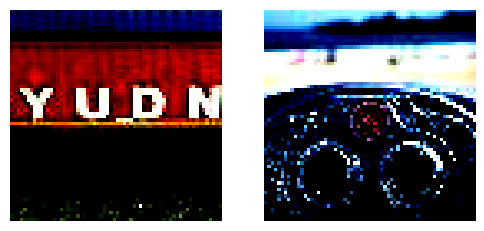

In [ ]:
show_images([tfm_train_ds[0][0], tfm_val_ds[0][0]]);

In [ ]:
x, y = tfm_train_ds[0]
x.shape, x.mean(), x.std(), x.min(), x.max(), y

(torch.Size([3, 64, 64]),
 tensor(-0.4641),
 tensor(0.7215),
 tensor(-1.7635),
 tensor(1.9089),
 52)

In [ ]:
x, y = tfm_val_ds[0]
x.shape, x.mean(), x.std(), x.min(), x.max(), y

(torch.Size([3, 64, 64]),
 tensor(-0.0899),
 tensor(0.9338),
 tensor(-1.7635),
 tensor(2.1901),
 197)

In [ ]:
def denorm(x):
    return (x * xstd + xmean).clip(0, 1)

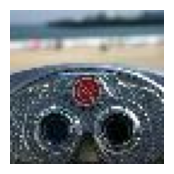

In [ ]:
show_image(denorm(x), figsize=(2, 2));

In [ ]:
words_lines = words_path.read_text().splitlines()
words_lines[-1]

'n15300051\t9/11, 9-11, September 11, Sept. 11, Sep 11'

In [ ]:
str2name = {}
for l in words_lines:
    wnid, name = l.split('\t')
    name = name.split(',')[0]
    str2name[wnid] = name

In [ ]:
str2name[id2str[y]]

'binoculars'

In [ ]:
train_dl = DataLoader(tfm_train_ds, batch_size=bs, shuffle=True, num_workers=4)

In [ ]:
xb, yb = next(iter(train_dl))

In [ ]:
def id2name(y):
    return str2name[id2str[y]]

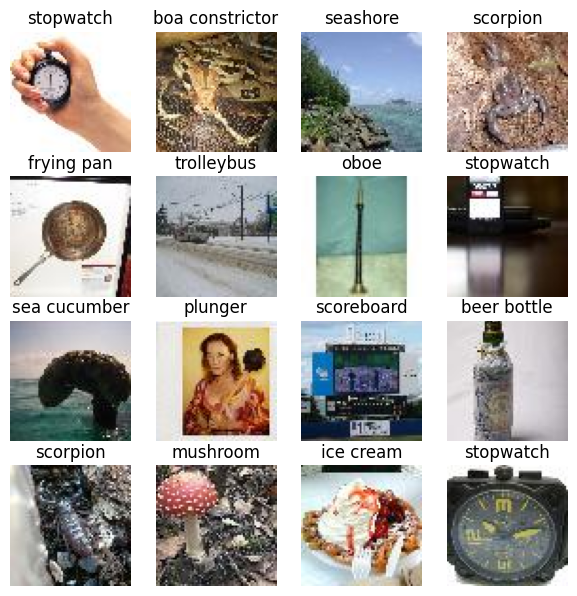

In [ ]:
show_images(denorm(xb[:16]), titles=map(id2name, yb[:16]), imsize=1.8);

In [ ]:
dls = DataLoaders(train_dl, DataLoader(tfm_val_ds, batch_size=bs*2, shuffle=False, num_workers=4))

## Basic model

In [ ]:
def tfm_batch(batch, x_tfm=fc.noop, y_tfm=fc.noop):
    return x_tfm(batch[0]), y_tfm(batch[1])

In [ ]:
import torchvision.transforms as transforms

In [ ]:
x.shape

torch.Size([3, 64, 64])

In [ ]:
transform = nn.Sequential(
    transforms.RandomCrop(size=64, padding=6),
    transforms.RandomHorizontalFlip(),
    RandErase(0.2, 5),
)
augment = BatchTransformCB(partial(tfm_batch, x_tfm=transform), on_valid=False)

In [ ]:
def get_model(act=act_gr, nfs=[16,32,64,128,256,512], norm=nn.BatchNorm2d, p_drop=0.2):
    model = nn.Sequential(
        ResBlock(3, 16, ks=5, stride=1, act=act, norm=norm), nn.Dropout2d(p_drop),
        *[ResBlock(nfs[i], nfs[i+1], act=act, stride=2, norm=norm) for i in range(len(nfs)-1)],
        nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(p_drop),
        nn.Linear(nfs[-1], len(id2str)), nn.BatchNorm1d(len(id2str))
    )
    return model

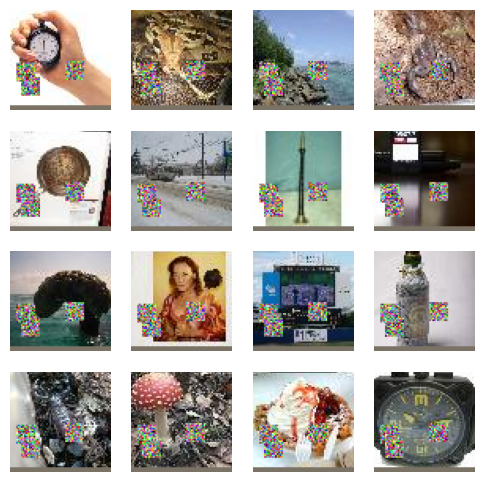

In [ ]:
show_images(denorm(transform(xb[:16])), imsize=1.5);

In [ ]:
init_w = partial(init_weights, leak=0.1)

In [ ]:
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(accuracy=MulticlassAccuracy())]

In [ ]:
opt_func = partial(optim.AdamW, eps=1e-4)

In [ ]:
set_seed(1103, False)
learn = TrainLearner(get_model(), dls, F.cross_entropy, lr=0.1, cbs=[SingleBatchCB(), augment, DeviceCB()], opt_func=optim.AdamW)
learn.fit(1)

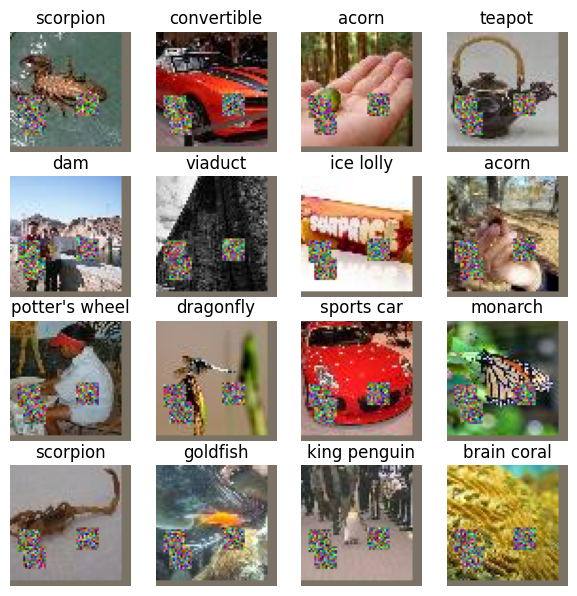

In [ ]:
show_images(denorm(to_cpu(learn.batch[0][:16])), titles=map(id2name, learn.batch[1][:16]), imsize=1.8);

In [ ]:
learn.summary()

TOTAL: params=5006280, ~MFLOPs=104.8


|Module|Input|Output|Num params|~MFLOPS|
|-|-|-|-|-|
|ResBlock|[256, 3, 64, 64]|[256, 16, 64, 64]|7760|31.3|
|Dropout2d|[256, 16, 64, 64]|[256, 16, 64, 64]|0|0.0|
|ResBlock|[256, 16, 64, 64]|[256, 32, 32, 32]|14560|14.7|
|ResBlock|[256, 32, 32, 32]|[256, 64, 16, 16]|57792|14.7|
|ResBlock|[256, 64, 16, 16]|[256, 128, 8, 8]|230272|14.7|
|ResBlock|[256, 128, 8, 8]|[256, 256, 4, 4]|919296|14.7|
|ResBlock|[256, 256, 4, 4]|[256, 512, 2, 2]|3673600|14.7|
|AdaptiveAvgPool2d|[256, 512, 2, 2]|[256, 512, 1, 1]|0|0.0|
|Flatten|[256, 512, 1, 1]|[256, 512]|0|0.0|
|Dropout|[256, 512]|[256, 512]|0|0.0|
|Linear|[256, 512]|[256, 200]|102600|0.1|
|BatchNorm1d|[256, 200]|[256, 200]|400|0.0|


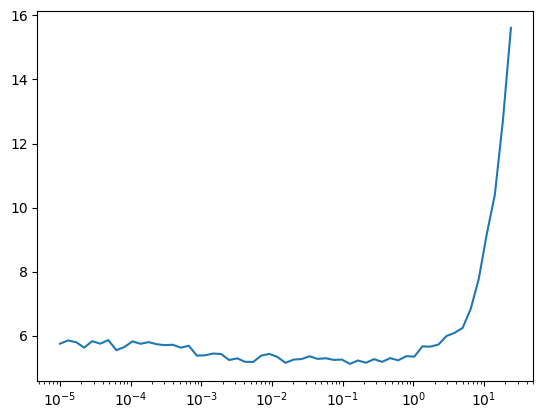

In [ ]:
set_seed(1103, False)
TrainLearner(get_model().apply(init_w), dls, F.cross_entropy, lr=0.1, cbs=[DeviceCB(), augment], opt_func=opt_func).lr_find()

accuracy,loss,epoch,train
0.090,4.508,0,train
0.139,4.033,0,valid
0.171,3.862,1,train
0.207,3.567,1,valid
0.203,3.590,2,train
0.219,3.507,2,valid
0.227,3.426,3,train
0.250,3.393,3,valid
0.247,3.312,4,train
0.274,3.185,4,valid


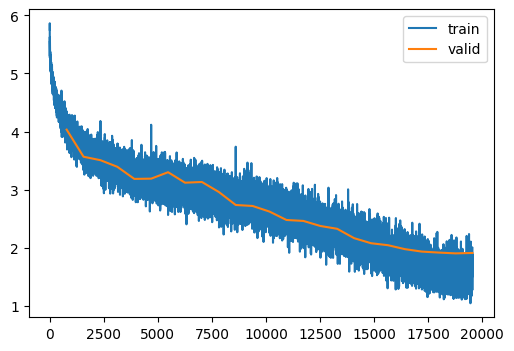

In [ ]:
epochs = 25
lr = 0.02
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))


set_seed(1103, False)
model = get_model()
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched, augment], opt_func=opt_func)
learn.fit(epochs)


In [ ]:
model_path = Path("models")
model_path.mkdir(exist_ok=True)
torch.save(learn.model, model_path / "24_imgnet_tiny_base_25.pkl")

In [ ]:
del learn
del model
clean_mem()

## Deeper

In [ ]:
def res_blocks(n_bk, ni, nf, stride, ks, act, norm):
    return nn.Sequential(*[
        ResBlock(ni if i == 0 else nf, nf, stride if n_bk - 1 == i else (ks - 1) // 2, ks, act, norm) for i in range(n_bk)
    ])

In [ ]:
def get_model(act=act_gr, nfs=[16,32,64,128,256,512], nbks=[3,4,3,2,1], norm=nn.BatchNorm2d, p_drop=0.2):
    model = nn.Sequential(
        ResBlock(3, 16, ks=5, stride=1, act=act, norm=norm), nn.Dropout2d(p_drop),
        *[res_blocks(nbks[i], nfs[i], nfs[i+1], ks=3, act=act, stride=2, norm=norm) for i in range(len(nfs)-1)],
        nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(p_drop),
        nn.Linear(nfs[-1], len(id2str)), nn.BatchNorm1d(len(id2str))
    )
    return model

In [ ]:
TrainLearner(get_model(), dls, F.cross_entropy, lr=0.1, cbs=[], opt_func=optim.AdamW).summary()

TOTAL: params=7038408, ~MFLOPs=255.8


|Module|Input|Output|Num params|~MFLOPS|
|-|-|-|-|-|
|ResBlock|[256, 3, 64, 64]|[256, 16, 64, 64]|7760|31.3|
|Dropout2d|[256, 16, 64, 64]|[256, 16, 64, 64]|0|0.0|
|Sequential|[256, 16, 64, 64]|[256, 32, 32, 32]|51808|52.4|
|Sequential|[256, 32, 32, 32]|[256, 64, 16, 16]|280128|71.3|
|Sequential|[256, 64, 16, 16]|[256, 128, 8, 8]|821632|52.4|
|Sequential|[256, 128, 8, 8]|[256, 256, 4, 4]|2100480|33.6|
|Sequential|[256, 256, 4, 4]|[256, 512, 2, 2]|3673600|14.7|
|AdaptiveAvgPool2d|[256, 512, 2, 2]|[256, 512, 1, 1]|0|0.0|
|Flatten|[256, 512, 1, 1]|[256, 512]|0|0.0|
|Dropout|[256, 512]|[256, 512]|0|0.0|
|Linear|[256, 512]|[256, 200]|102600|0.1|
|BatchNorm1d|[256, 200]|[256, 200]|400|0.0|


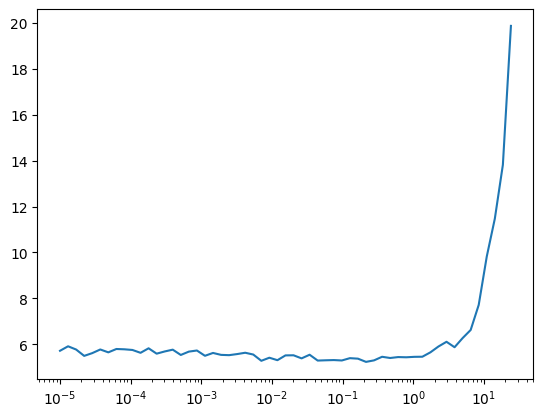

In [ ]:
set_seed(1103, False)
TrainLearner(get_model().apply(init_w), dls, F.cross_entropy, lr=0.1, cbs=[DeviceCB(), augment], opt_func=opt_func).lr_find()

In [ ]:
dls = DataLoaders(train_dl, DataLoader(tfm_val_ds, batch_size=bs, shuffle=False, num_workers=4))

accuracy,loss,epoch,train
0.064,4.700,0,train
0.132,4.060,0,valid
0.167,3.839,1,train
0.210,3.569,1,valid
0.223,3.449,2,train
0.257,3.270,2,valid
0.264,3.211,3,train
0.292,3.074,3,valid
0.287,3.070,4,train
0.300,3.046,4,valid


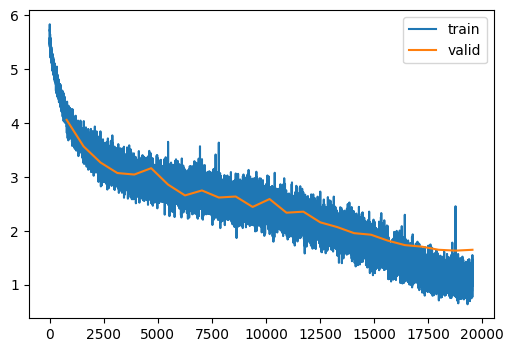

In [ ]:
epochs = 25
lr = 0.03
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))


set_seed(1103, False)
model = get_model()
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched, augment], opt_func=opt_func)
learn.fit(epochs)

In [ ]:
model_path = Path("models")
model_path.mkdir(exist_ok=True)
torch.save(learn.model, model_path / "24_imgnet_tiny_deep_25.pkl")

In [ ]:
del learn
del model
clean_mem()

## More augmentation

In [ ]:
transforms.TrivialAugmentWide?

Init signature:
transforms.TrivialAugmentWide(
    num_magnitude_bins: int = 31,
    interpolation: torchvision.transforms.functional.InterpolationMode = <InterpolationMode.NEAREST: 'nearest'>,
    fill: Optional[List[float]] = None,
) -> None
Docstring:     
Dataset-independent data-augmentation with TrivialAugment Wide, as described in
`"TrivialAugment: Tuning-free Yet State-of-the-Art Data Augmentation" <https://arxiv.org/abs/2103.10158>`_.
If the image is torch Tensor, it should be of type torch.uint8, and it is expected
to have [..., 1 or 3, H, W] shape, where ... means an arbitrary number of leading dimensions.
If img is PIL Image, it is expected to be in mode "L" or "RGB".

Args:
    num_magnitude_bins (int): The number of different magnitude values.
    interpolation (InterpolationMode): Desired interpolation enum defined by
        :class:`torchvision.transforms.InterpolationMode`. Default is ``InterpolationMode.NEAREST``.
        If input is Tensor, only ``InterpolationMode.N

In [ ]:
from PIL import Image

In [ ]:
img = read_image(tiny_ds[0][0], mode=ImageReadMode.RGB)

In [ ]:
train_transform_prenorm = nn.Sequential(
    transforms.RandomCrop(size=64, padding=6),
    transforms.RandomHorizontalFlip(),
    transforms.TrivialAugmentWide()
)
aug_img = train_transform_prenorm(img)

In [ ]:
xmean = xmean.to(def_device)
xstd = xmean.to(def_device)
def normalize(x):
    x = x.to(dtype=torch.float32) / 255.
    return (x - xmean) / xstd
train_transform_postnorm = RandErase(0.2, 5)

In [ ]:
aug_img = train_transform_prenorm(img)
print(aug_img.dtype)
aug_img = to_cpu(normalize(aug_img.cuda()))
print(aug_img.dtype)
aug_img = train_transform_postnorm = RandErase(0.2, 5)

torch.uint8
torch.float32


In [ ]:
augment_prenorm = BatchTransformCB(
    partial(tfm_batch, x_tfm=train_transform_prenorm),
    on_valid=False
)
augment_norm = BatchTransformCB(
    partial(tfm_batch, x_tfm=normalize),
    on_valid=True
)
augment_norm.order = augment_prenorm.order + 0.01
augment_postnorm = BatchTransformCB(
    partial(tfm_batch, x_tfm=train_transform_postnorm),
    on_valid=False
)
augment_postnorm.order = augment_norm.order + 0.01
augments = [augment_prenorm, augment_norm, augment_postnorm]

In [ ]:
def tfmx(x):
    return read_image(x, mode=ImageReadMode.RGB)

bs = 64
tfm_train_ds = TfmDS(tiny_ds, x_tfms=tfmx, y_tfms=tfmy)
tfm_val_ds = TfmDS(val_ds, x_tfms=tfmx, y_tfms=tfmy)
dls = DataLoaders(
    DataLoader(tfm_train_ds, batch_size=bs, shuffle=True, num_workers=4),
    DataLoader(tfm_val_ds, batch_size=bs, shuffle=False, num_workers=4)
)

In [ ]:
def get_model(act=act_gr, nfs=[16,32,64,128,256,512,1024], nbks=[3,4,3,2,2,1], norm=nn.BatchNorm2d, p_drop=0.2):
    model = nn.Sequential(
        ResBlock(3, 16, ks=5, stride=1, act=act, norm=norm), nn.Dropout2d(p_drop),
        *[res_blocks(nbks[i], nfs[i], nfs[i+1], ks=3, act=act, stride=2, norm=norm) for i in range(len(nfs)-1)],
        nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(p_drop),
        nn.Linear(nfs[-1], len(id2str)), nn.BatchNorm1d(len(id2str))
    )
    return model

In [ ]:
set_seed(1103, False)
learn = TrainLearner(get_model(), dls, F.cross_entropy, lr=0.1, cbs=[SingleBatchCB(), *augments, DeviceCB()], opt_func=opt_func)
learn.fit(1)

In [ ]:
learn.summary()

TOTAL: params=26549704, ~MFLOPs=289.5


|Module|Input|Output|Num params|~MFLOPS|
|-|-|-|-|-|
|ResBlock|[64, 3, 64, 64]|[64, 16, 64, 64]|7760|31.3|
|Dropout2d|[64, 16, 64, 64]|[64, 16, 64, 64]|0|0.0|
|Sequential|[64, 16, 64, 64]|[64, 32, 32, 32]|51808|52.4|
|Sequential|[64, 32, 32, 32]|[64, 64, 16, 16]|280128|71.3|
|Sequential|[64, 64, 16, 16]|[64, 128, 8, 8]|821632|52.4|
|Sequential|[64, 128, 8, 8]|[64, 256, 4, 4]|2100480|33.6|
|Sequential|[64, 256, 4, 4]|[64, 512, 2, 2]|8395264|33.6|
|Sequential|[64, 512, 2, 2]|[64, 1024, 1, 1]|14687232|14.7|
|AdaptiveAvgPool2d|[64, 1024, 1, 1]|[64, 1024, 1, 1]|0|0.0|
|Flatten|[64, 1024, 1, 1]|[64, 1024]|0|0.0|
|Dropout|[64, 1024]|[64, 1024]|0|0.0|
|Linear|[64, 1024]|[64, 200]|205000|0.2|
|BatchNorm1d|[64, 200]|[64, 200]|400|0.0|


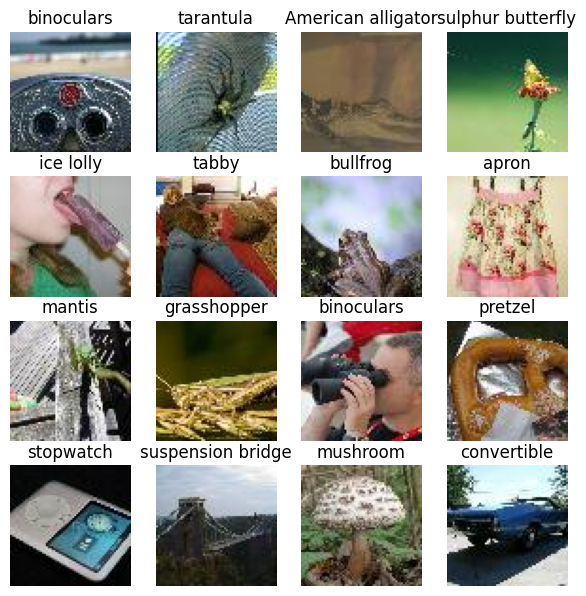

In [ ]:
show_images(to_cpu(denorm(learn.batch[0][:16])), titles=map(id2name, learn.batch[1][:16]), imsize=1.8);

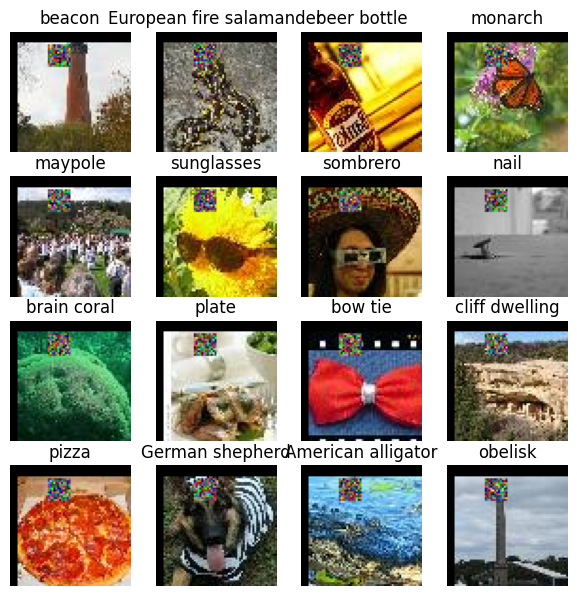

In [ ]:
learn.fit(1)
show_images(to_cpu(denorm(learn.batch[0][:16])), titles=map(id2name, learn.batch[1][:16]), imsize=1.8);

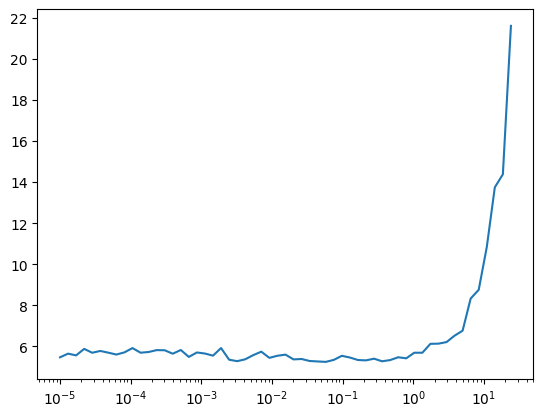

In [ ]:
set_seed(1103, False)
TrainLearner(get_model().apply(init_w), dls, F.cross_entropy, lr=0.1, cbs=[DeviceCB(), *augments], opt_func=opt_func).lr_find()

accuracy,loss,epoch,train
0.026,5.066,0,train
0.056,4.661,0,valid
0.073,4.540,1,train
0.119,4.154,1,valid
0.114,4.169,2,train
0.162,3.924,2,valid
0.143,3.943,3,train
0.197,3.653,3,valid
0.163,3.816,4,train
0.202,3.639,4,valid


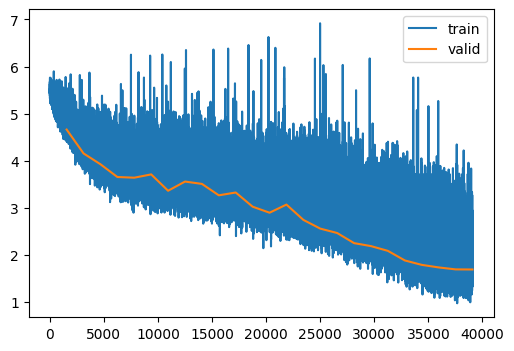

In [ ]:
epochs = 25
lr = 0.03
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))


set_seed(1103, False)
model = get_model()
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched, *augments], opt_func=opt_func)
learn.fit(epochs)

In [ ]:
model_path = Path("models")
model_path.mkdir(exist_ok=True)
torch.save(learn.model, model_path / "24_imgnet_tiny_deep_wide_aug_25.pkl")